##### **Disclaimer: We use some advanced packages here without detailed explanation. You can use these, but we do not provide any support.**

In [1]:
# To install them, you can uncomment the following lines:
# (%pip will call pip from the currently active python environment)

# Note: Some of these packages are still not compatible with Python 3.12 yet
# %pip install sweetviz
# %pip install ydata_profiling
# %pip install shap

## CRISP-DM

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Note: The following do not work with Python 3.12
import shap
from ydata_profiling import ProfileReport
import sweetviz as sv

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


This toy example serves to give a first impression of how a CRISP-DM adhering 
data science project could be implemented. CRISP-DM 

<img src="crisp_dm.png" width="500">

#### Reproducibility 

A best practice in data analytics projects is to work with *seeds* to ensure the reproducability of results. 
This is especially important in the Analytics Cup, since the rules require you to write a self-contained
script that produces reproducable results. 

To achieve this, we can set seeds for all used random number generators.

In [4]:
seed = 2024

# pandas, statsmode
# ls, matplotlib and y_data_profiling rely on numpy's random generator, and thus, we need to set the seed in numpy
np.random.seed(seed)

### Phase 1: Business Understanding

Business Understanding is the first and economically most important step in the
CRISP-DM process. It serves to assess use cases, feasibility, requirements, and
risks of the endeavored data driven project. Since the conduction of data driven
projects usually depends on the data at hand, the CRISP-DM process often 
alternates between Business Understanding and Data Understanding, until the
project's schedule becomes sufficiently clear.

#### Example: Business Understanding

In our toy example, we want to provide a service to customers that can identify 
iris flowers. The use case could be an automatic price assignment to flowers sold
at a shop, because some varieties of the flower could be more rare and thus more
expensive. This would save huge amounts of manual labour and associated costs. 
In this example, assume that the Business Understanding part has already been 
iterated sufficiently often, such that the project plan is clear: 

Train a suitable model (classifier) that can distinguish iris flower varieties. 
The data that you need to achieve the task has already been collected for you 
and is fully provided in a .csv file.

### Phase 2: Data Understanding

The *Data Understanding* phase mainly serves to inform the Business Understanding step by
assessing the data quality and content, and should provide the engineers with 
an intuition for the specific data and the specific problem at hand. Experienced
data scientists and machine learning engineers can often estimate the difficulty
and feasibility of the task by analyzing and understanding the data.  

#### Example: Data Understanding

Make yourself familiar with the structure and content of the data. *Note*, this step 
heavily depends on the specific problem at hand, since there is no fixed recipe that 
fits all possible data sets. In the example below, we are only looking at a very small
data set and do **not** conduct an in-depth analysis.  

In [5]:
# load the data
file_path = "iris_dataset.csv"
df = pd.read_csv(file_path)

In [6]:
# have a look at the data and its attributes
print(df.sample(10))

# check if columns are properly named
# ---> yes

     sepal.length  sepal.width  petal.length  petal.width     variety
14            5.8          4.0           1.2          0.2      Setosa
37            4.9          3.6           1.4          0.1      Setosa
78            6.0          2.9           4.5          1.5  Versicolor
138           6.0          3.0           4.8          1.8   Virginica
46            5.1          3.8           1.6          0.2      Setosa
76            6.8          2.8           4.8          1.4  Versicolor
81            5.5          2.4           3.7          1.0  Versicolor
145           6.7          3.0           5.2          2.3   Virginica
35            5.0          3.2           1.2          0.2      Setosa
17            5.1          3.5           1.4          0.3      Setosa


In [7]:
# get a general overview over data, check for missing values, etc.
print(df.info())

# --> we have 150 rows, and no attribute has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


       sepal.length  sepal.width  petal.length  petal.width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


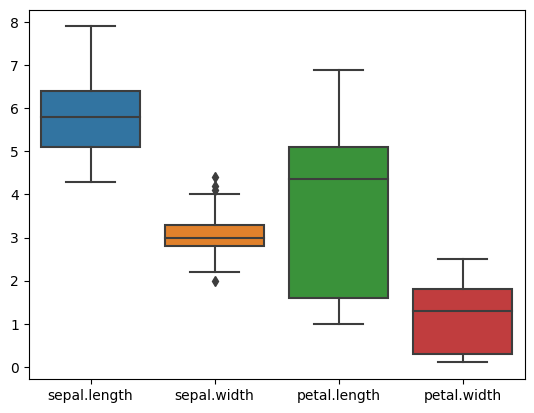

In [8]:
# have a look at common statistics of the dataset
print(df.describe())
sns.boxplot(df);

In [9]:
# check the balancing of classes/labels
print(df.groupby("variety").size())

# -> 3 classes, each equally frequent

variety
Setosa        50
Versicolor    50
Virginica     50
dtype: int64


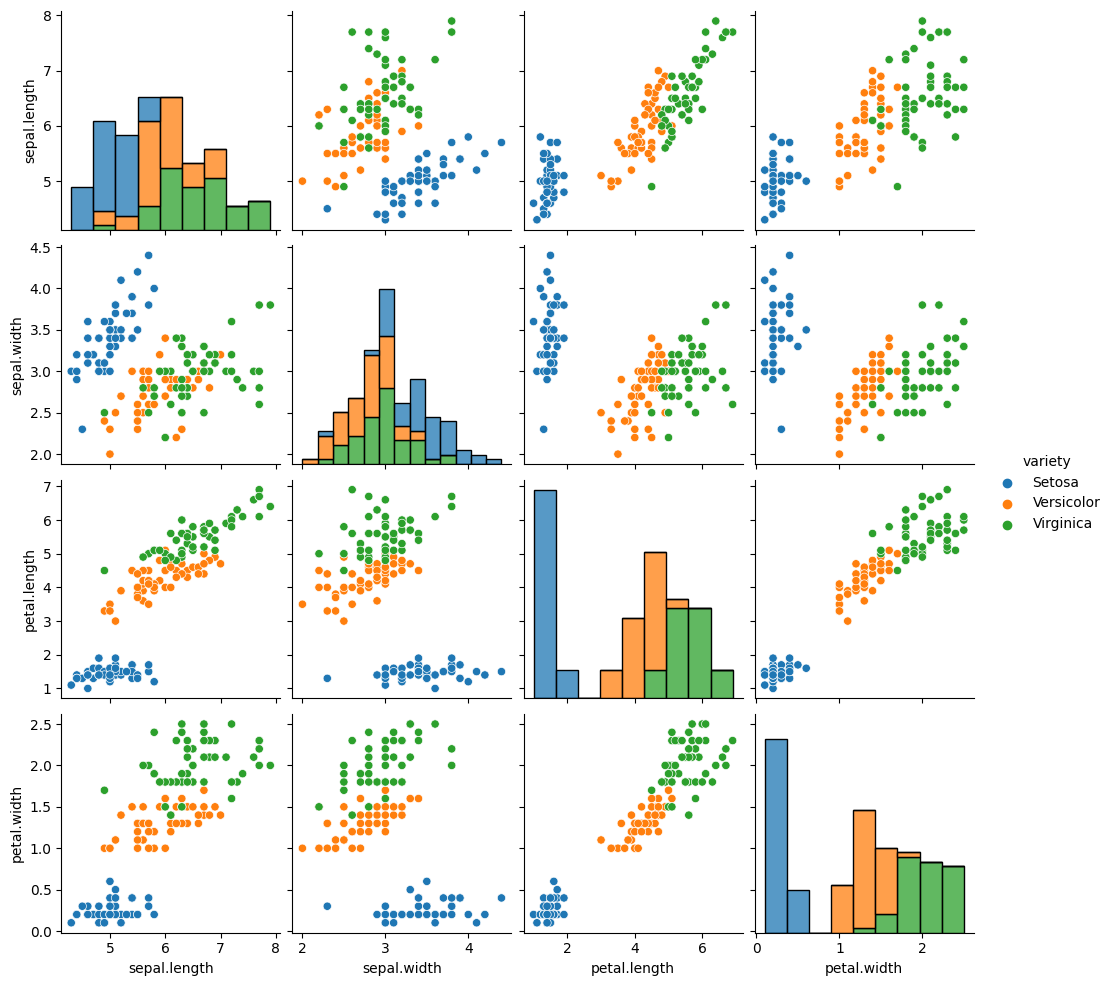

In [10]:
# have a look at the feature distributions with a pairplot,
# as it gives you a good overview over possible outliers
# and a good overview over the data in general

# pairplot for the full data
sns.pairplot(df, hue="variety", diag_kind="hist", diag_kws={"multiple" : "stack"});

# -> looks like the dataset doesn't have any obvious extreme outliers, but maybe
# some points could still be considered outliers (depending on criteria)
# -> looks like "Versicolor" and "Virginica" are not linearly seperable

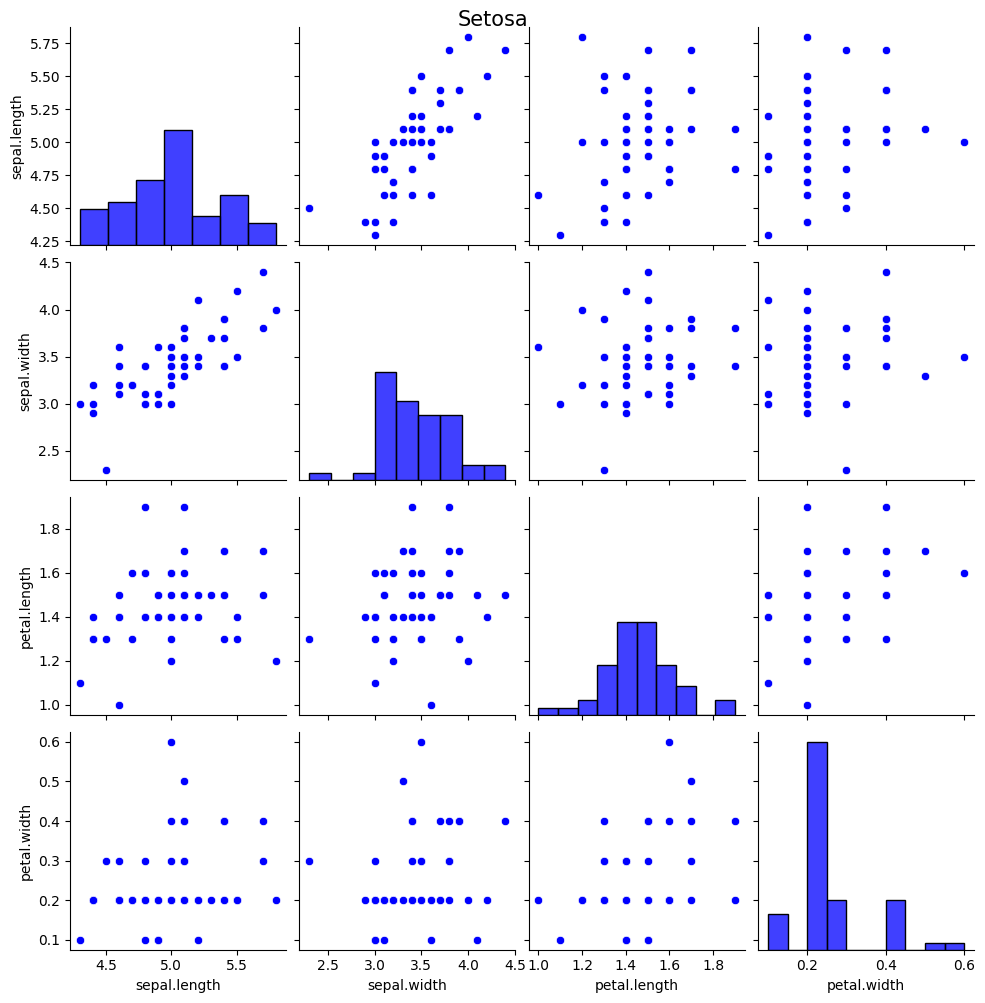

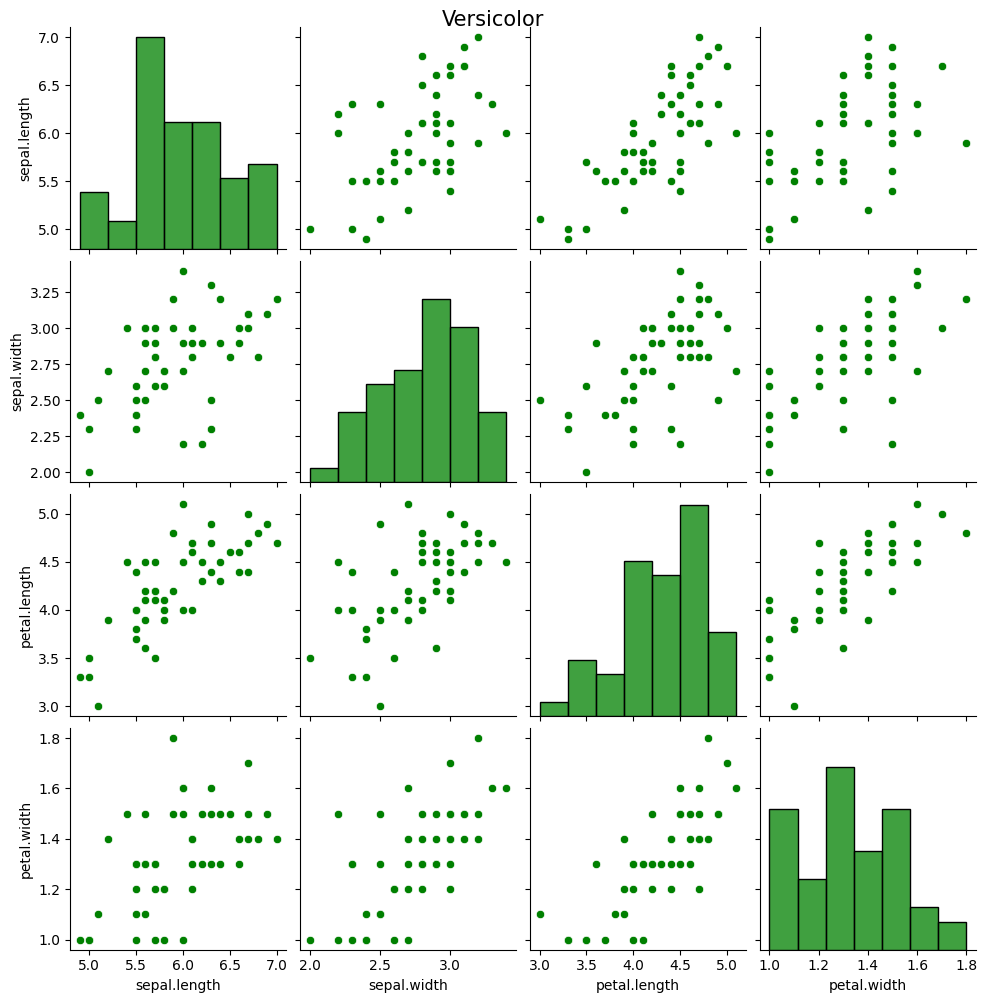

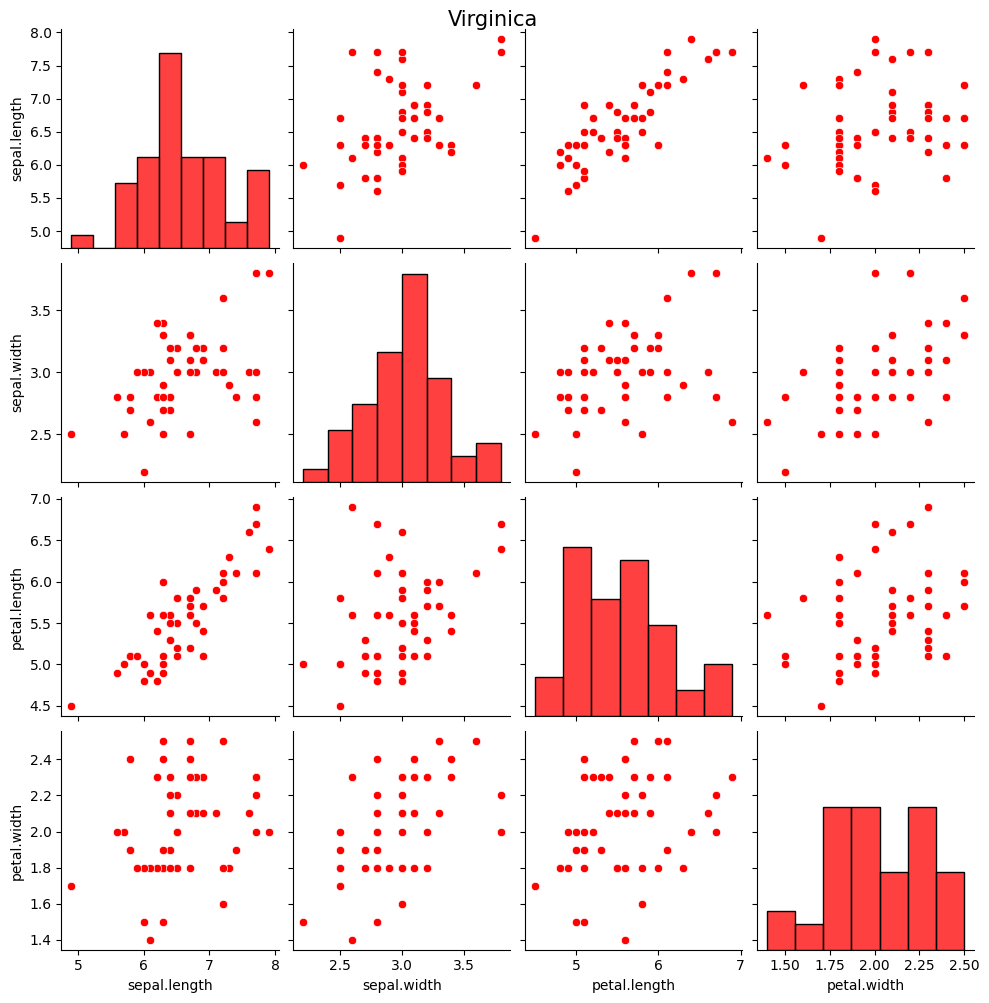

In [11]:
# look at class-dependent pairplots
df_grouped_by_class = df.groupby(by="variety")

df_setosa = df_grouped_by_class.get_group("Setosa")
df_versicolor = df_grouped_by_class.get_group("Versicolor")
df_virginica = df_grouped_by_class.get_group("Virginica")

class_labels = {
    "Setosa" : {
        "color" : "blue",
        "data" : df_setosa
    },
    "Versicolor" : {
        "color" : "green",
        "data" : df_versicolor
    },
    "Virginica" : {
        "color" : "red",
        "data" : df_virginica
    }
}

for class_i in class_labels:
    class_color = class_labels[class_i]["color"]
    class_df = class_labels[class_i]["data"]
    p = sns.pairplot(class_df, diag_kind="hist", diag_kws={"color" : class_color}, plot_kws={"color" : class_color, "label" : class_i})
    p.fig.suptitle(class_i, y=1.0, size=15)

In [ ]:
# We can also leverage the dataprep package to get a nice summary report
report = sv.analyze(df)
report.show_notebook()

# We can also leverage the yadata_profiling package to get a nice summary report
profile = ProfileReport(df, title="Iris Data - Summary Report")
profile

#### Summary: Data Understanding

You should have a good understanding what the data is about and of some of its properties. Newly gained insights are used to reiterate the
Business Understanding Phase, but in this example, it won't be necessary.

### Phase 3: Data Preparation

Data Preparation mainly consists of two parts, Data Cleaning and Data Wrangling. In Data
Cleaning, the goal is assure data quality. This includes removing wrong/corrupt 
data entries and making sure the entries are standardized, e.g. enforcing certain encodings. 
Data Wrangling then transforms the data in order to make it suitable for the modelling step.
Sometimes, steps from Data Wrangling are incorporated into the automatized Pipeline, as
we will show in this example.

#### Data Cleaning

In this example, the dataset is already cleaned. Everything is properly named,
the datatypes and encodings are consistent, there are no corrupt or missing values, etc.
Our cleaning effort is limited to transforming the feature *variety* into a categorical 
variable. 

In practise, this will rarely be the case. On average, this step takes up to **80%** of 
the time of the whole project.

In [12]:
### data cleaning

# transform data to numerical / categorical
df["variety"] = df["variety"].astype("category")

# fill/remove/change missing/corrupt values
# -> already done here, but this will be much effort in general

# optionally save the cleaned datasets for versioning

#### Data Wrangling

In contrast to Data Cleaning, Data Wrangling _transforms_ the dataset, in order
to prepare it for the training of the models. This includes scaling, dimensionality
reduction, data augmentation, outlier removal, etc.

Again, this is just a toy example with an already cleaned data set. Thus, we are not 
going to demonstrate any specific data wrangling steps here. However, this is a very
tedious exercise in practice. 

In [13]:
### data wrangling

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# data scaling
transform_scaler = StandardScaler()

# dimensionality reduction
transform_pca = PCA()

# value imputing

# outlier detection/removal

#### Sampling

Once we have a cleaned data set, and before we start the *Modelling* phase, we are going to split our data set into multiple sub-datasets. 
Here, we are going to split it into an *train* and *test* data set. Note that the split strongly depends on the underlying use-case
and used dataset.  

In [14]:
# split data into learning and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
  train_test_split(df.iloc[:, :-1], df.iloc[:, -1:],
                   test_size=0.3, 
                   shuffle=True,
                   random_state=3)


### Phase 4: Modeling

In this phase, the model is trained and tuned. In general, data transformations
from data wrangling can be part of a machine learning pipeline, and can therefore
be tuned as well. (See CRISP-DM: DataPrep <--> Modeling)

In [15]:
# Here, you want to find the best classifier. As candidates, consider
#   1. LogisticRegression
#   2. RandomForestClassifier
#   3. other algorithms from sklearn (easy to add)
#   4. custom algorithms (more difficult to implement)
    
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_logistic_regression = LogisticRegression(max_iter=30)
model_random_forest = RandomForestClassifier()
model_gradient_boosting = GradientBoostingClassifier()

# train the models
pipeline = Pipeline(steps=[("scaler", transform_scaler), 
                           ("pca", transform_pca),
                           ("model", None)])

parameter_grid_preprocessing = {
  "pca__n_components" : [1, 2, 3, 4],
}

parameter_grid_logistic_regression = {
  "model" : [model_logistic_regression],
  "model__C" : [0.1, 1, 10],  # inverse regularization strength
}

parameter_grid_gradient_boosting = {
  "model" : [model_gradient_boosting],
  "model__n_estimators" : [10, 20, 30]
}

parameter_grid_random_forest = {
  "model" : [model_random_forest],
  "model__n_estimators" : [10, 20, 50],  # number of max trees in the forest
  "model__max_depth" : [2, 3, 4],
}

meta_parameter_grid = [parameter_grid_logistic_regression,
                       parameter_grid_random_forest,
                       parameter_grid_gradient_boosting]

meta_parameter_grid = [{**parameter_grid_preprocessing, **model_grid}
                       for model_grid in meta_parameter_grid]

search = GridSearchCV(pipeline,
                      meta_parameter_grid, 
                      scoring="balanced_accuracy",
                      n_jobs=2, 
                      cv=5,  # number of folds for cross-validation 
                      error_score="raise"
)

# here, the actual training and grid search happens
search.fit(X_train, y_train.values.ravel())

print("best parameter:", search.best_params_ ,"(CV score=%0.3f)" % search.best_score_)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

best parameter: {'model': GradientBoostingClassifier(n_estimators=20), 'model__n_estimators': 20, 'pca__n_components': 3} (CV score=0.966)


### Step 5: Evaluation

Once the appropriate models are chosen, they are evaluated on the test set. For
this, different evaluation metrics can be used. Furthermore, this step is where
the models and their predictions are analyzed resp. different properties, including
feature importance, robustness to outliers, etc.

In [ ]:
# evaluate performance of model on test set
print("Score on test set:", search.score(X_test, y_test.values.ravel()))

# contingency table
ct = pd.crosstab(search.best_estimator_.predict(X_test), y_test.values.ravel(),
                 rownames=["pred"], colnames=["true"])
print(ct)

In [ ]:
# (optional, if you're curious) 
# for a detailed look on the performance of the different models
def get_search_score_overview():
  for c,s in zip(search.cv_results_["params"],search.cv_results_["mean_test_score"]):
      print(c, s)

print(get_search_score_overview())

#### Interpretability

##### Disclaimer: This only works if shap is installed.

In addition to models and their predictions, it is often important to understand _why_ a model makes certain predictions. 
There is a lot of literature on how this can be achieved (explainability), but we will only show the use of Shapley values
using the python module "shap", which is a combination of Shapley values and LIME. 
You can find more information on this topic [here](https://christophm.github.io/interpretable-ml-book/shap.html).

In [ ]:
# assume random forest model
model = RandomForestClassifier(n_estimators=10, random_state=seed)
model.fit(X_train, y_train.values.ravel())

# compute shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)

expected_value = explainer.expected_value
print(expected_value)

In [ ]:
# class dependent plots of shapley values for each feature
for i,c in enumerate(df.variety.unique()):
    shap.summary_plot(shap_values[i], X_train, show=False)
    plt.title("Shapley values for "+str(c))
    plt.show()

From the computed SHAP values, we can interpret that the *petal.width* has a positive impact on the output of the model 
if the feature value is moderate. For high aand low values, the impact is negative. The same observation
holds for *petal.length*. Besides, the impact of the *sepal.length* and *sepal.width* features are rather low. By impact on a 
the target, we model the probability that we classify that target. Thus, if *petal.width* is high, it is more likely
that we classify the data point as Versicolor.

### Step 6: Deployment

Now that you have chosen and trained your model, it is time to deploy it to your
clients system. 

In [ ]:
def micro_service_classify_iris(datapoint):
    
  # make sure the provided datapoints adhere to the correct format for model input

  # fetch your trained model
  model = search.best_estimator_

  # make prediction with the model
  prediction = model.predict(datapoint)

  return prediction


In [ ]:
# hypothetical new batch of flowers arrives
from scipy.stats import norm

amount_of_new_flowers = 9
df_flowers = pd.DataFrame(columns=df.columns.drop("variety"), index=range(1, amount_of_new_flowers+1))

for i in df_flowers.index:
  df_flowers.loc[i, "sepal.length"] = norm(loc=6, scale=2).rvs()
  df_flowers.loc[i, "sepal.width"] = norm(loc=3, scale=1).rvs()
  df_flowers.loc[i, "petal.length"] = norm(loc=3, scale=5).rvs()
  df_flowers.loc[i, "petal.width"] = norm(loc=2, scale=2).rvs()

# customer uses your micro service to determine the varieties
df_flowers["variety"] = micro_service_classify_iris(df_flowers)
print(df_flowers)

In the Analytics Cup, you need to export your prediction in a very specific output format. This is a csv file without an index and two columns, *id* and *prediction*. Note that the values in both columns need to be integer values, and especially in the *prediction* column either 1 or 0.

In [ ]:
# Let's assume that our id column is the index of the dataframe
output = pd.DataFrame(df_flowers.variety)
output['id'] = df_flowers.index
output = output.rename(columns={'variety': 'prediction'})
output = output.reindex(columns=["id", "prediction"])
output.to_csv('iris_prediction.csv', index=False)